In [31]:
#import dependencies
import numpy as np
import pandas as pd
import tweepy
import time
import json
import datetime as dt
import csv
from time import sleep
from pprint import pprint
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import seaborn as sns
from config import consumer_key, consumer_secret, access_token, access_token_secret
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# Twitter API Keys
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_token_secret = access_token_secret

In [32]:
# Twitter Credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [38]:
def TwitterBot():
    target_sn,requester,requesting_id = identify_check_request()
    (compound_list,
    tweet_num_list,
    target_sn,requester,
    requesting_id) = search_for_tweets(target_sn,requester,requesting_id)
    analyze_and_plot(compound_list,tweet_num_list,target_sn,requester,requesting_id)
    
def identify_check_request():
    print('Looking for a tweet that mentions me on my page...')
    #Declare local variables
    target_sn = ''
    requester = ''
    requesting_id = ''
    list_of_targets = []
    # Look at the most recent tweet on the bot's timeline and extract text content and author's sn
    request_tweet = api.user_timeline('@AwayMikes',count=1,result_type='recent')
    request_text = request_tweet[0]['text']
    requester = '@'+request_tweet[0]['user']['screen_name']
    requesting_id = request_tweet[0]['id_str']
    # For simplicity sake, extract the last element that was split on @
    # presumably this will be the target SN, if it is not, it will be handled later
    _sn_start = request_text.rfind('@')
    at_to_end = request_text[_sn_start:]
    split_on_space = at_to_end.split(' ')
    target_sn = split_on_space[0]
    # Open the list_of_targets datafile and read rows into memory
    with open ('list_of_targets.csv',newline='') as csvfile:
        target_reader = csv.reader(csvfile,delimiter=',')
        for row in target_reader:
            list_of_targets.append(row[0])
    # Check to see if the target has already been analyzed
    if target_sn not in list_of_targets:
        try:
            search_for_tweets(target_sn,requester,requesting_id)
        except tweepy.TweepError:
            api.update_status("Something went wrong, I'm going to take a #nap")
            gotosleep()
    if target_sn in list_of_targets:
        try:
            api.update_with_media(f"{target_sn}.png",
                                  f"I'm sorry {requester}, {target_sn} has already been analyzed. Here is the plot: ",
                                  requesting_id)
        except tweepy.TweepError:
            print("Could not find the file, kill me!")
    if target_sn == '@AwayMikes':
        gotosleep()
    return target_sn,requester,requesting_id
    
def search_for_tweets(target_sn,requester,requesting_id):
    print(f"Target acquired ({target_sn}), now searching for {target_sn}'s tweets!")
    tweets_ago = 0
    # Variable for holding the oldest tweet
    oldest_tweet = None

    # Variables for holding sentiments
    compound_list = []
    tweet_num_list = []

    # Loop through 25 times
    for x in range(25):

        # Pull a page of tweets from the target_sn's timeline
        public_tweets = api.user_timeline(target_sn, page=x, result_type="recent")

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]

            # Add each value to the appropriate list
            compound_list.append(compound)
            
            #Increment the num_tweets to count the tweets from most recent
            tweet_num_list.append(tweets_ago)
            tweets_ago -= 1
                
    # return the lists and target_sn for next method
    return compound_list,tweet_num_list,target_sn,requester,requesting_id

def analyze_and_plot(compound_list,tweet_num_list,target_sn,requester,requesting_id):
    print('Beginning to plot...')
    # Begin by constructing dataframe from tweet polarity lists
    tweetdf = pd.DataFrame(compound_list,columns=['Compound Score'])
    # Rename index to tweets ago value
    tweetdf.set_axis(tweet_num_list,axis=0,inplace=True)
    # Define Seaborn style and generate plot
    sns.set_style('darkgrid')
    tweetplot = sns.tsplot(data=tweetdf['Compound Score'],time=tweetdf.index.values,condition=['Compound Score'])
    # Label x and y axes
    tweetplot.set_ylabel('Tweet Polarity')
    tweetplot.set_xlabel('Tweets Ago')
    # Set ylimit higher than possible value to accomodate legend
    tweetplot.set_ylim(bottom=-1,top=1.25)
    # Create a patch for the legend to reflect the target_sn
    user = mpatches.Patch(label=target_sn)
    tweetplot.legend(handles=[user],loc=1)
    # Save the file to post later
    plt.savefig((f'{target_sn}'),dpi=300)
    # Save the target to the list_of_targets.csv
    with open ('list_of_targets.csv','w',newline='') as csvfile:
        target_writer = csv.writer(csvfile,delimiter=',')
        target_writer.writerow([target_sn])
    # Tweet out the generated plot
    api.update_with_media(f"{target_sn}.png",
                          f"Here you go {requester}, {target_sn}'s sentiment analysis: ",
                          requesting_id)
    # Go to sleep
    gotosleep()


def gotosleep():
    print("I am now going to sleep!")
    sleep(300)
    TwitterBot()

Looking for a tweet that mentions me on my page...
Target acquired (@realDonaldTrump), now searching for @realDonaldTrump's tweets!
Target acquired (@realDonaldTrump), now searching for @realDonaldTrump's tweets!
Beginning to plot...


/anaconda3/envs/data/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


I am now going to sleep!
Looking for a tweet that mentions me on my page...
Target acquired (@realDonaldTrump), now searching for @realDonaldTrump's tweets!
Beginning to plot...
I am now going to sleep!
Looking for a tweet that mentions me on my page...
Target acquired (p), now searching for p's tweets!
Target acquired (p), now searching for p's tweets!
Beginning to plot...
I am now going to sleep!


KeyboardInterrupt: 

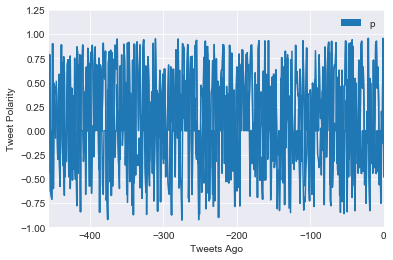

In [39]:
TwitterBot()

/anaconda3/envs/data/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


'@RealDonaldTrump'

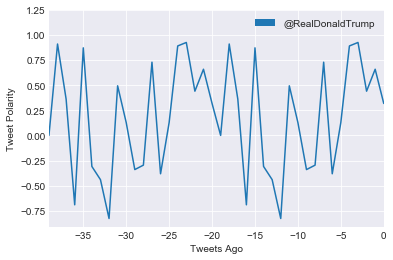